![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/4bd64c1deb3c4ffb8ca7ff93c1f1497d).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

### 

In [1]:
# Importación librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xg
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

import joblib
import werkzeug
from werkzeug.utils import cached_property
from flask import Flask

try:
    from flask_restplus import Api, Resource, fields
except ImportError:
    import werkzeug
    werkzeug.cached_property = werkzeug.utils.cached_property
    from flask_restplus import Resource, Api, fields

In [2]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

In [3]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [4]:
XTotal = dataTraining.loc[:,dataTraining.columns!="Price"]
yTotal = dataTraining.loc[:,dataTraining.columns=="Price"]
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

## Exploración de Datos

In [ ]:
##Buscamos valores Nulos en las variables.
XTrain.isnull().sum()

In [ ]:
print(XTrain['Year'].describe())
XTrain['Year'].value_counts()

In [ ]:
print(XTrain['Mileage'].describe())
XTrain['Mileage'].value_counts()

In [ ]:
print(XTrain['State'].describe())
XTrain['State'].value_counts()

In [ ]:
print(XTrain['Make'].describe())
XTrain['Make'].value_counts()

In [ ]:
print(XTrain['Model'].describe())
XTrain['Model'].value_counts()

## Transformación de Datos

In [5]:
XTrain.State = XTrain.State.str.replace(' ', '')
XTrain['YearsBetween']=2022-XTrain['Year']
XTrain['MileagebyYear']=XTrain['Mileage']/XTrain['YearsBetween']
State=pd.get_dummies(XTrain["State"], prefix='State')
XTrain=pd.concat([XTrain, State], axis=1)
Make=pd.get_dummies(XTrain["Make"], prefix='Make')
XTrain=pd.concat([XTrain, Make], axis=1)
Model=pd.get_dummies(XTrain["Model"], prefix='Model')
XTrain=pd.concat([XTrain, Model], axis=1)
XTrain=XTrain.drop(["State","Make","Model","Make_Freightliner"], axis=1)
XTrain

,Year,Mileage,YearsBetween,MileagebyYear,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,...,Model_Yaris4dr,Model_YarisBase,Model_YarisLE,Model_Yukon,Model_Yukon2WD,Model_Yukon4WD,Model_Yukon4dr,Model_tC2dr,Model_xB5dr,Model_xD5dr
219421,2012,52027,10,5202.700000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187898,2015,18127,7,2589.571429,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298770,2013,122197,9,13577.444444,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217760,2014,38003,8,4750.375000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195247,2015,49464,7,7066.285714,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,2012,41501,10,4150.100000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
358083,2010,77127,12,6427.250000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
152315,2015,34896,7,4985.142857,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117952,2016,3946,6,657.666667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
XTest.State = XTest.State.str.replace(' ', '')
XTest['YearsBetween']=2022-XTest['Year']
XTest['MileagebyYear']=XTest['Mileage']/XTest['YearsBetween']
State=pd.get_dummies(XTest["State"], prefix='State')
XTest=pd.concat([XTest, State], axis=1)
Make=pd.get_dummies(XTest["Make"], prefix='Make')
XTest=pd.concat([XTest, Make], axis=1)
Model=pd.get_dummies(XTest["Model"], prefix='Model')
XTest=pd.concat([XTest, Model], axis=1)
XTest=XTest.drop(["State","Make","Model","Make_Freightliner"], axis=1)
XTest

,Year,Mileage,YearsBetween,MileagebyYear,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,...,Model_Yaris4dr,Model_YarisBase,Model_YarisLE,Model_Yukon,Model_Yukon2WD,Model_Yukon4WD,Model_Yukon4dr,Model_tC2dr,Model_xB5dr,Model_xD5dr
242160,2010,115991,12,9665.916667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3413,2014,48093,8,6011.625000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
393024,2016,5494,6,915.666667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247987,2016,43217,6,7202.833333,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
52436,2013,37664,9,4184.888889,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239061,2010,167325,12,13943.750000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237666,2013,63520,9,7057.777778,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40562,2016,32595,6,5432.500000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136654,2017,5,5,1.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Ajuste de Modelo Sin Calibración

In [7]:
# Instantiation
xgb_r = xg.XGBRegressor()

# Fitting the model
xgb_r.fit(XTrain, yTrain)
  
# Predict the model
pred = xgb_r.predict(XTest)
  
# RMSE Computation
rmse_base = np.sqrt(MSE(yTest, pred))
print("RMSE : % f" %(rmse_base))

RMSE :  4321.718015


## Proceso de Calibración

### ¡Advertencia!
### Este proceso puede tomar más de 4hrs

In [ ]:
# learning_rate calibration

learning_rate_range = np.linspace(0.01, 0.5, num=10)
accuracy_scores = []

for learning_rate in learning_rate_range:
    
    clf = xg.XGBRegressor(objective='reg:squarederror',learning_rate=learning_rate, verbosity = 0)

    # Fitting the model
    clf.fit(XTrain, yTrain)

    # Predict the model
    pred = clf.predict(XTest)

    # RMSE Computation
    rmse=np.sqrt(MSE(yTest, pred))
    accuracy_scores.append(rmse)
    print(learning_rate,rmse)
plt.plot(learning_rate_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()
print(" Alcanzamos el minimo RMSE con learning_rate = " + str(learning_rate_range[np.argmin(accuracy_scores)]))

In [ ]:
### gamma calibration
gamma_range = np.linspace(0.01, 0.5, num=10)
accuracy_scores = []
for gamma in gamma_range:
    
    clf = xg.XGBRegressor(objective='reg:squarederror',learning_rate=0.5,gamma=gamma, verbosity = 0 )
    
    # Fitting the model
    clf.fit(XTrain, yTrain)

    # Predict the model
    pred = clf.predict(XTest)

    # RMSE Computation
    rmse=np.sqrt(MSE(yTest, pred))
    accuracy_scores.append(rmse)
    print(gamma,rmse)
    
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('RMSE')
plt.show()
print(" Alcanzamos el minimo RMSE con gamma = " + str(gamma_range[np.argmin(accuracy_scores)]))

In [ ]:
colsample_bytree_range = np.linspace(0.01, 0.5, num=10)
accuracy_scores = []
for colsample_bytree in colsample_bytree_range:
    
    clf = xg.XGBRegressor(objective ='reg:linear',learning_rate=0.5 ,gamma=0.01, colsample_bytree=colsample_bytree, verbosity = 0 )
    
    # Fitting the model
    clf.fit(XTrain, yTrain)

    # Predict the model
    pred = clf.predict(XTest)

    # RMSE Computation
    rmse=np.sqrt(MSE(yTest, pred))
    accuracy_scores.append(rmse)
    print(colsample_bytree,rmse)
    
print(colsample_bytree_range[np.argmin(accuracy_scores)])
plt.plot(colsample_bytree_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')
plt.show()

In [ ]:
max_depth_range  = range(5, 15,1)

accuracy_scores = []
for max_depth in max_depth_range:
    
    clf = xg.XGBRegressor(objective='reg:squarederror',learning_rate=0.5 ,gamma=0.01, colsample_bytree=0.5,max_depth=max_depth, verbosity = 0 )
    
    # Fitting the model
    clf.fit(XTrain, yTrain)

    # Predict the model
    pred = clf.predict(XTest)

    # RMSE Computation
    rmse=np.sqrt(MSE(yTest, pred))
    accuracy_scores.append(rmse)
    print(max_depth,rmse)
    
print(max_depth_range[np.argmin(accuracy_scores)])
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

In [ ]:
alpha_range  = range(1, 10)

accuracy_scores = []
for alpha in alpha_range:
    
    clf = xg.XGBRegressor(objective='reg:squarederror',learning_rate=0.5 ,gamma=0.01, colsample_bytree=0.5,max_depth=13,alpha=alpha ,verbosity = 0 )
    
    # Fitting the model
    clf.fit(XTrain, yTrain)

    # Predict the model
    pred = clf.predict(XTest)

    # RMSE Computation
    rmse=np.sqrt(MSE(yTest, pred))
    accuracy_scores.append(rmse)
    print(alpha,rmse)
    
print(max_depth_range[np.argmin(accuracy_scores)])
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.show()

In [ ]:
min_child_weight_range = range(3,15,3)

accuracy_scores = []
for min_child_weight in min_child_weight_range:
    
    clf = xg.XGBRegressor(objective='reg:squarederror',learning_rate=0.5 ,gamma=0.01, colsample_bytree=0.5,max_depth=13,alpha=7, min_child_weight=min_child_weight ,verbosity = 0 )
    
    # Fitting the model
    clf.fit(XTrain, yTrain)

    # Predict the model
    pred = clf.predict(XTest)

    # RMSE Computation
    rmse=np.sqrt(MSE(yTest, pred))
    accuracy_scores.append(rmse)
    print(min_child_weight,rmse)
    
print(min_child_weight_range[np.argmin(accuracy_scores)])
plt.plot(min_child_weight_range, accuracy_scores)
plt.xlabel('min_child_weight')
plt.ylabel('RMSE')
plt.show()

In [ ]:
subsample_range = np.linspace(0.01, 1, num=10)

accuracy_scores = []
for subsample in subsample_range:
    
    clf = xg.XGBRegressor(objective='reg:squarederror',learning_rate=0.5 ,gamma=0.01, colsample_bytree=0.5,max_depth=13,alpha=7, min_child_weight=9, subsample=subsample ,verbosity = 0 )
    
    # Fitting the model
    clf.fit(XTrain, yTrain)

    # Predict the model
    pred = clf.predict(XTest)

    # RMSE Computation
    rmse=np.sqrt(MSE(yTest, pred))
    accuracy_scores.append(rmse)
    print(subsample,rmse)
    
print(subsample_range[np.argmin(accuracy_scores)])
plt.plot(subsample_range, accuracy_scores)
plt.xlabel('subsample')
plt.ylabel('RMSE')
plt.show()

In [ ]:
num_boost_round_range = range(100,200,10)

housing_dmatrix = xg.DMatrix(data=XTrain, label=yTrain)

# Creata the parameter dictionary for each tree: params
params = {"objective":"reg:squarederror",
"learning_rate":0.5,
"gamma":0.01, 
"colsample_bytree":0.5, 
"max_depth":13,
"alpha":7, 
"min_child_weight":9, 
"n_estimators":100}


# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Interate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_boost_round_range:
    print(curr_num_rounds)
    # Perform cross-validation: cv_results
    cv_results = xg.cv( dtrain=housing_dmatrix,
                       params=params, nfold=3, 
                        num_boost_round=curr_num_rounds, metrics='rmse', 
                        as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results['test-rmse-mean'].tail().values[-1])
    
# Print the result DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))

print(pd.DataFrame(num_rounds_rmses, columns=['num_boosting_rounds', 'rmse']))
print(subsample_range[np.argmin(accuracy_scores)])
plt.plot(num_boost_round, final_rmse_per_round)
plt.xlabel('subsample')
plt.ylabel('RMSE')
plt.show()

## Entrenar  Modelo Calibrado

In [8]:
# Modelo calibrado
clf = xg.XGBRegressor(objective='reg:squarederror',learning_rate=0.5,gamma=0.01, colsample_bytree=0.5, max_depth=13,alpha=7, min_child_weight=9,subsample=1,n_estimators=100,num_boost_round=150, verbosity = 0 )    
# Fitting the model
clf.fit(XTrain, yTrain)
# Predict the model
pred = clf.predict(XTest)
# RMSE Computation
rmse_cal=np.sqrt(MSE(yTest, pred))
print('RMSE:',rmse_cal)

RMSE: 3622.525365237105


### Graficamos la imprtacia de la variables

<BarContainer object of 617 artists>

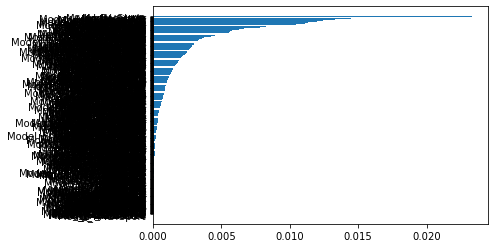

In [9]:
orden= clf.feature_importances_.argsort()
plt.barh(XTrain.columns[orden],clf.feature_importances_[orden])

### Eliminamos las variables que no aportan al modelo

In [10]:
indice=[]
for i in range(0,617):
    if clf.feature_importances_[i]>0.00:
        indice.append(i)

In [11]:
columnas=XTrain.columns[indice]

XTrain=XTrain[columnas]
XTest=XTest[columnas]

print(XTrain.shape,XTest.shape)

(268000, 549) (132000, 549)


### Ajustamos el modelo con los cambios apliacado

In [21]:
# Modelo calibrado
clf = xg.XGBRegressor(objective='reg:squarederror',learning_rate=0.5,gamma=0.01, colsample_bytree=0.5, max_depth=13,alpha=7, min_child_weight=9,subsample=1,n_estimators=100,num_boost_round=150, verbosity = 0 )    

# Fitting the model
clf.fit(XTrain, yTrain)
# Predict the model
pred = clf.predict(XTest)
# RMSE Computation
rmse_cal=np.sqrt(MSE(yTest, pred))
print('RMSE:',rmse_cal)
#3,592

RMSE: 3592.369250472476


In [ ]:
orden= clf.feature_importances_.argsort()
plt.barh(XTrain.columns[orden],clf.feature_importances_[orden])

## Guardar el Modelo Calibrado

In [19]:
# Exportar modelo a archivo binario .pkl
joblib.dump(clf, 'modelo_precio_autos_calibrado.pkl', compress=3)

['modelo_precio_autos_calibrado.pkl']

In [20]:
# Importar modelo y predicción
from predice_precio_model_deployment import predice_precio

# Predicción de precio  de  un auto
predice_precio(2017,9913,'FL','Jeep','Wrangler') 
#34995

array([39944.926], dtype=float32)

## Resultados

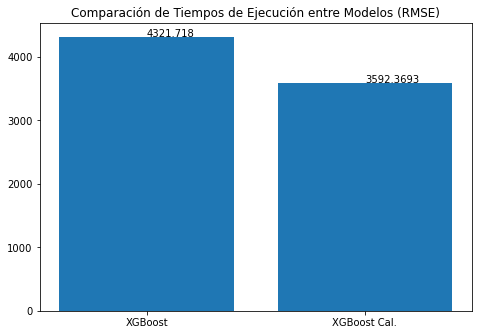

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de Tiempos de Ejecución entre Modelos (RMSE)")
ejeX = ['XGBoost','XGBoost Cal.']
ejeY = [float(round(rmse_base,4)),float(round(rmse_cal,4))]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

## Perfilando datos de Test

In [22]:
# Visualización datos de test
dataTesting = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTest_carListings.zip', index_col=0)

dataTesting.State = dataTesting.State.str.replace(' ', '')
dataTesting['YearsBetween']=2022-dataTesting['Year']
dataTesting['MileagebyYear']=dataTesting['Mileage']/dataTesting['YearsBetween']
State=pd.get_dummies(dataTesting["State"], prefix='State')
dataTesting=pd.concat([dataTesting, State], axis=1)
Make=pd.get_dummies(dataTesting["Make"], prefix='Make')
dataTesting=pd.concat([dataTesting, Make], axis=1)
Model=pd.get_dummies(dataTesting["Model"], prefix='Model')
dataTesting=pd.concat([dataTesting, Model], axis=1)
dataTesting=dataTesting.drop(["State","Make","Model"], axis=1)
dataTesting= dataTesting[columnas]

In [23]:
pred = clf.predict(dataTesting)

In [24]:
# Guardar predicciones en formato exigido en la competencia de kaggle
yPred=pd.DataFrame(pred,columns=['Price'])
# Exportamos a un archivo los resultados
yPred.to_csv('test_submission.csv', index_label='ID')
yPred.head()

,Price
0,20592.542969
1,34226.058594
2,22646.255859
3,6659.804199
4,31237.859375


## Disponibilizar modelo con Flask

Para esta sección del notebook instale las siguientes librerías *!pip install flask* y *!pip install flask_restplus*.

In [ ]:
from predice_precio_model_deployment import predice_precio

# Definición aplicación Flask
app = Flask(__name__)

# Definición API Flask
api = Api(
    app, 
    version='1.0', 
    title='API de Predicción de Precios de Autos',
    description='API de Predicción de Precios de Autos')

ns = api.namespace('predict', 
     description='Regresión de Precio de Auto')

# Definición argumentos o parámetros de la API
parser = api.parser()

parser.add_argument(
    'Year', 
    type=int, 
    required=True, 
    help='Año del modelo', 
    location='args')

parser.add_argument(
    'Mileage', 
    type=int, 
    required=True, 
    help='Millas recorridas', 
    location='args')

parser.add_argument(
    'State', 
    type=str, 
    required=True, 
    help='Estado de procedencia', 
    location='args')

parser.add_argument(
    'Make', 
    type=str, 
    required=True, 
    help='Marca de la ensambladora de auto', 
    location='args')

parser.add_argument(
    'Model', 
    type=str, 
    required=True, 
    help='Sub marca del auto', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})

In [ ]:
# Definición de la clase para disponibilización
@ns.route('/')
class PhishingApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        print(args)
        return {
         "result": predice_precio(args['Year'],args['Mileage'],args['State'],args['Make'],args['Model'])
        }, 200

In [ ]:
# Ejecución de la aplicación que disponibiliza el modelo de manera local en el puerto 5000
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5002)

In [ ]:
(alpha=7, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=13, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=2, nthread=2,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=7, reg_lambda=1, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1)